In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix

In [2]:
# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

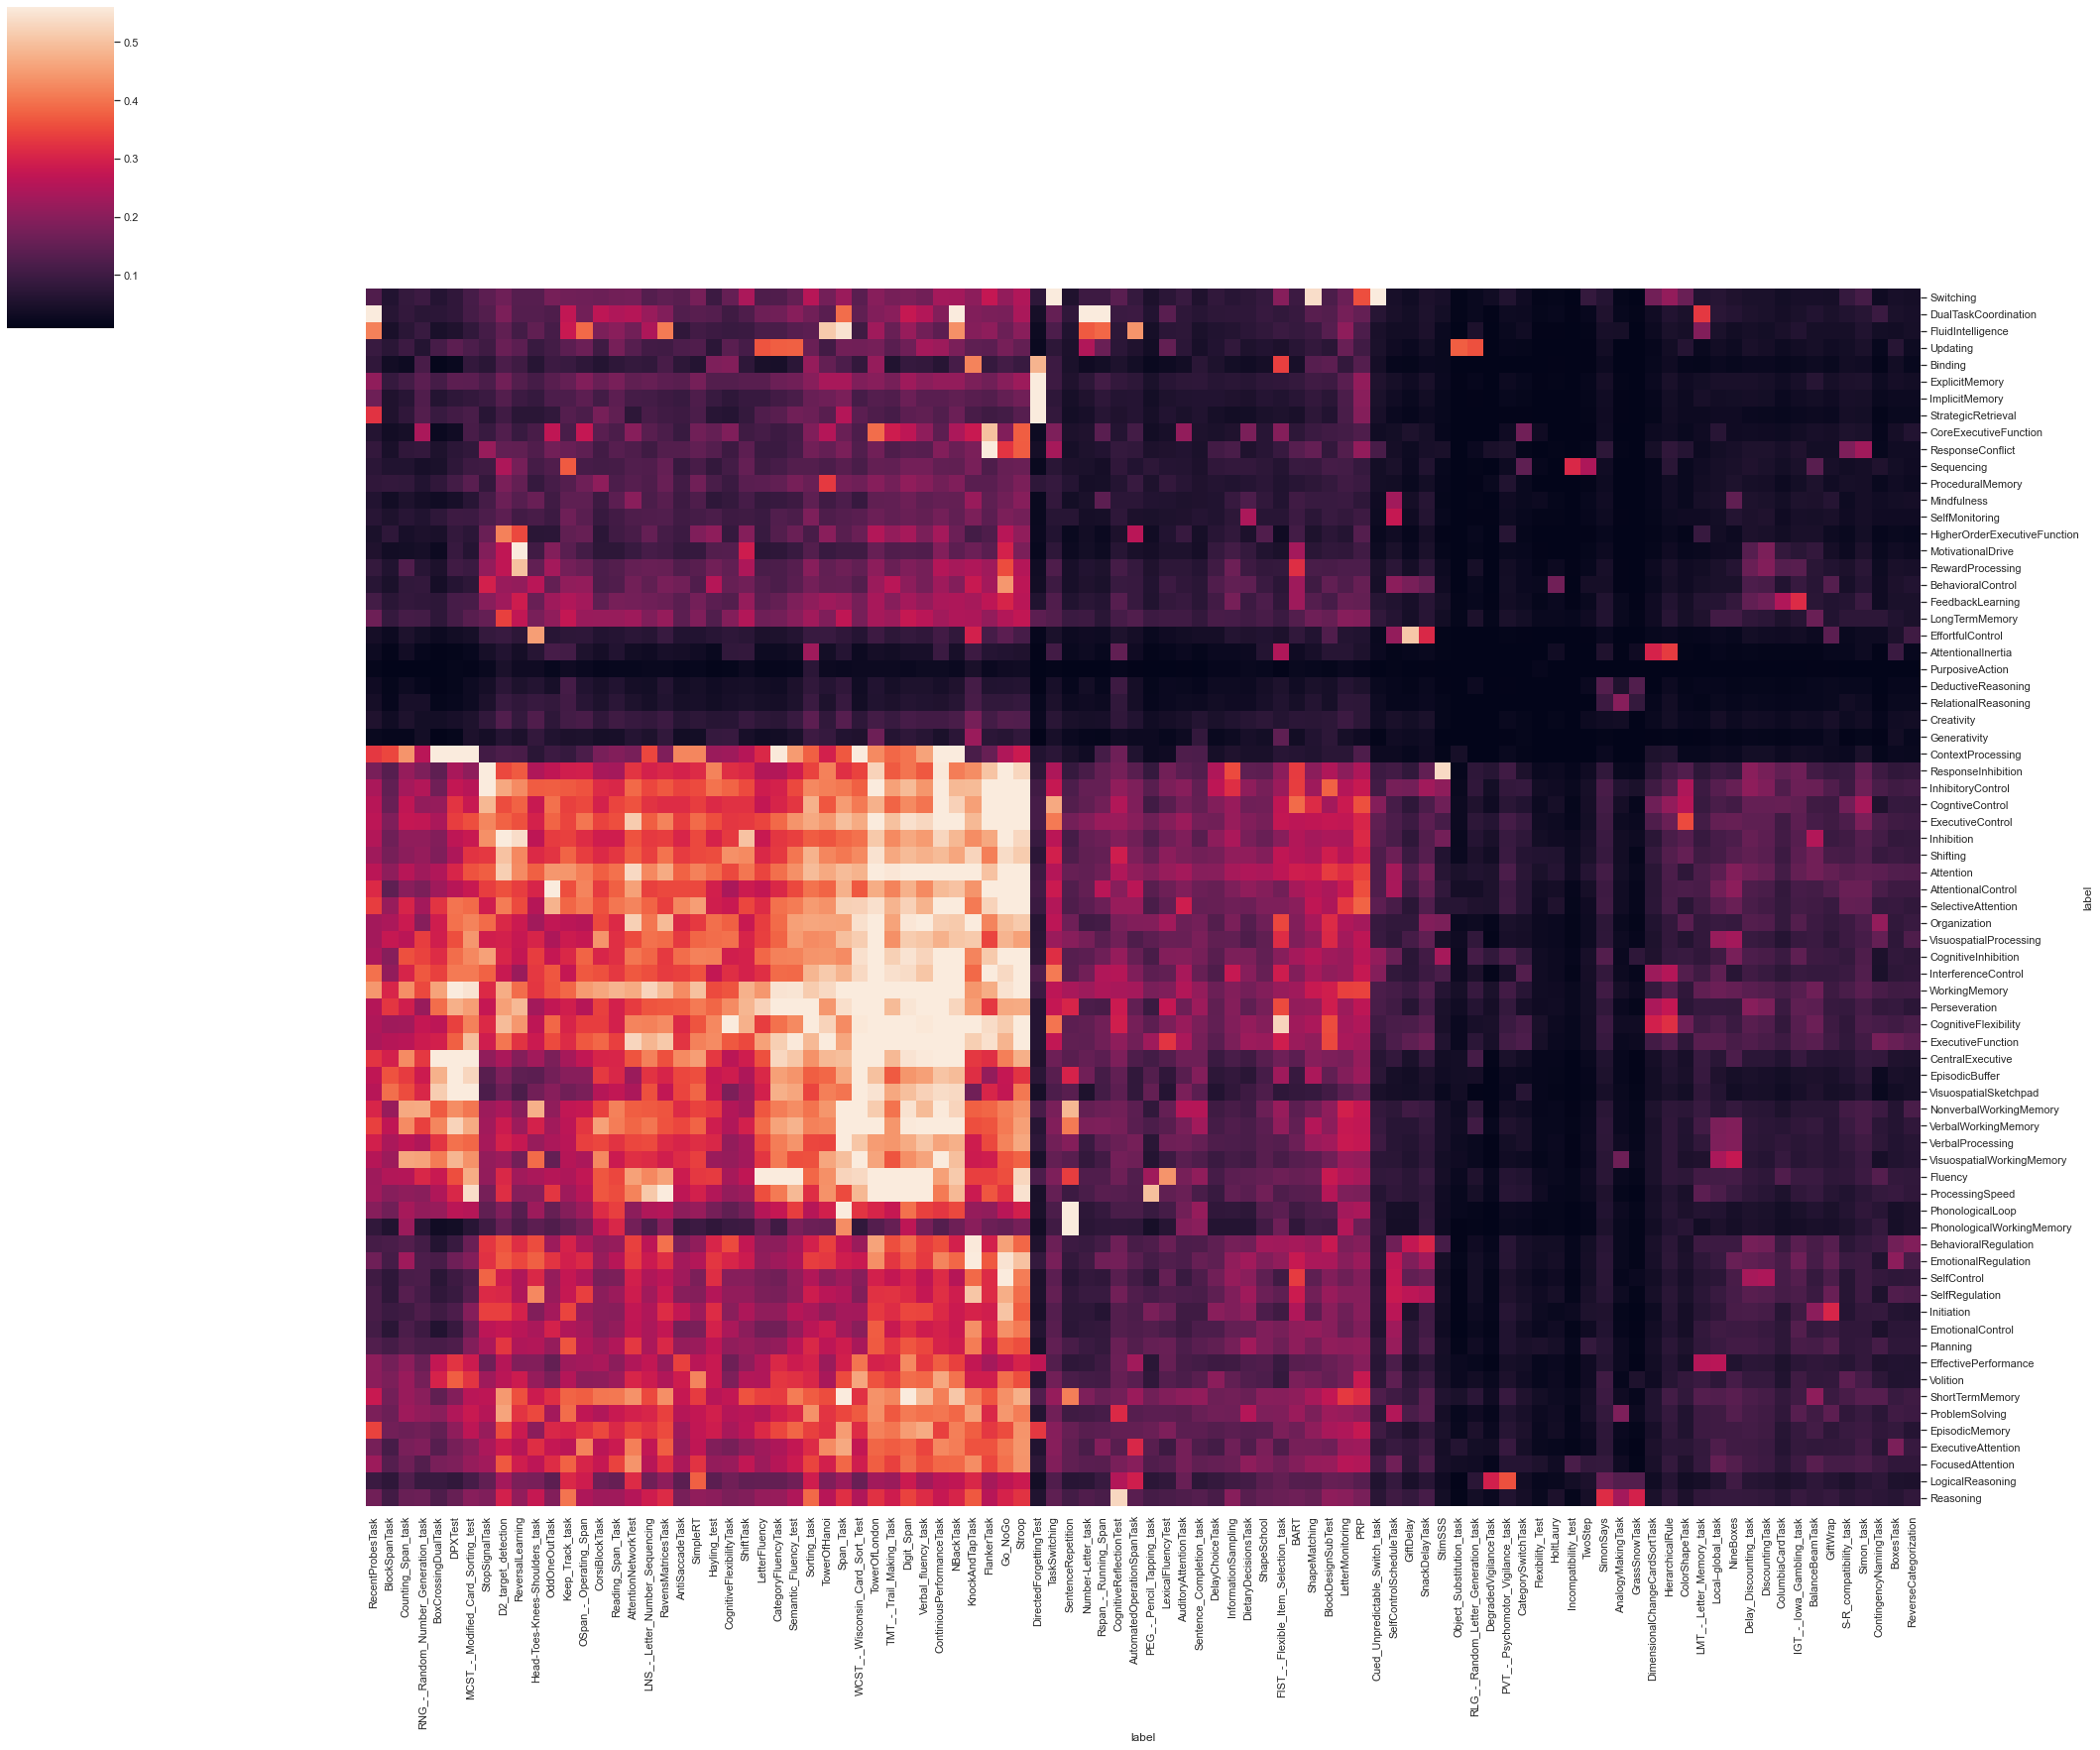

In [4]:
# plot label-label similarity matrix

# create label-embeddings by mean-pooling doc-embeddings of each label
label_embeddings = pubmed.groupby('label')['weights'].apply(np.mean)
label_embeddings = pd.DataFrame(np.stack(label_embeddings), index=label_embeddings.index)

def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]

# add categories of labels
label_embeddings['category'] = label_embeddings.index.to_series().apply(find_category_by_label)
label_embeddings.set_index(['category'], append=True, inplace=True)

# now generate the similarity matrix
labels_sim = get_similarity_matrix(label_embeddings, metric='cosine')

# heatmap plot categorized by label category, either task or construct
g = sns.clustermap(labels_sim, figsize=(30, 25), robust=True)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
plt.show()

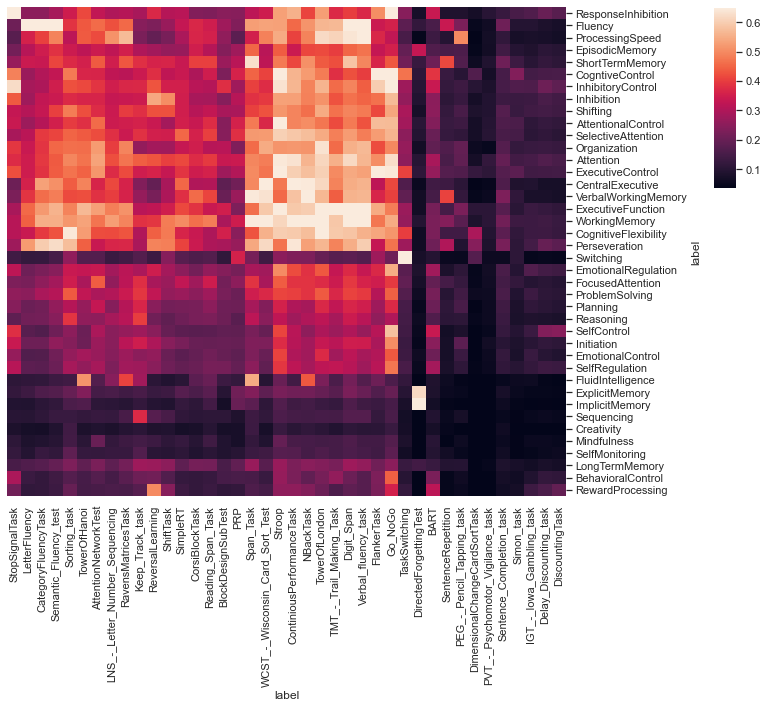

In [86]:
# plot only 30 popular tasks and 30 popular constructs

n_popular_labels = 40

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())
popular_label_embeddings = label_embeddings.query('label in @popular_labels')
popular_labels_sim = get_similarity_matrix(popular_label_embeddings, metric='cosine')

g = sns.clustermap(popular_labels_sim, robust=True,
                   dendrogram_ratio=0.0001, 
                   cbar_pos=(1.0, 0.73, 0.03, 0.25),
                  #  cmap='RdBu', cmap='viridis',
                  )
# g.ax_row_dendrogram.set_visible(False)
# g.ax_col_dendrogram.set_visible(False)
plt.show()

In [ ]:
# metapath2vec embeddings

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


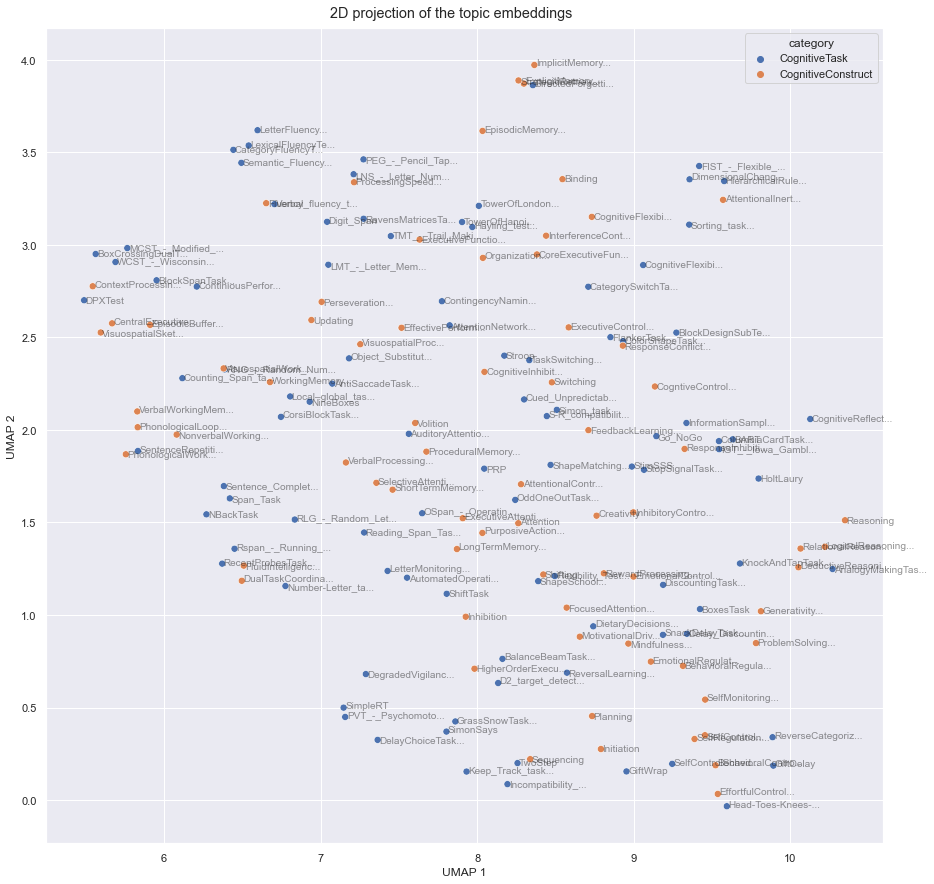

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15,15))

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections = UMAP(n_components=2, random_state=0).fit_transform(label_embeddings)

projections = pd.DataFrame(projections, index=label_embeddings.index)

sns.scatterplot(data=projections, x=0, y=1, ax=ax, s=50, hue='category')

for ((lbl,_), x, y) in projections.itertuples():
  lbl = f'{lbl[:16]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=10)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

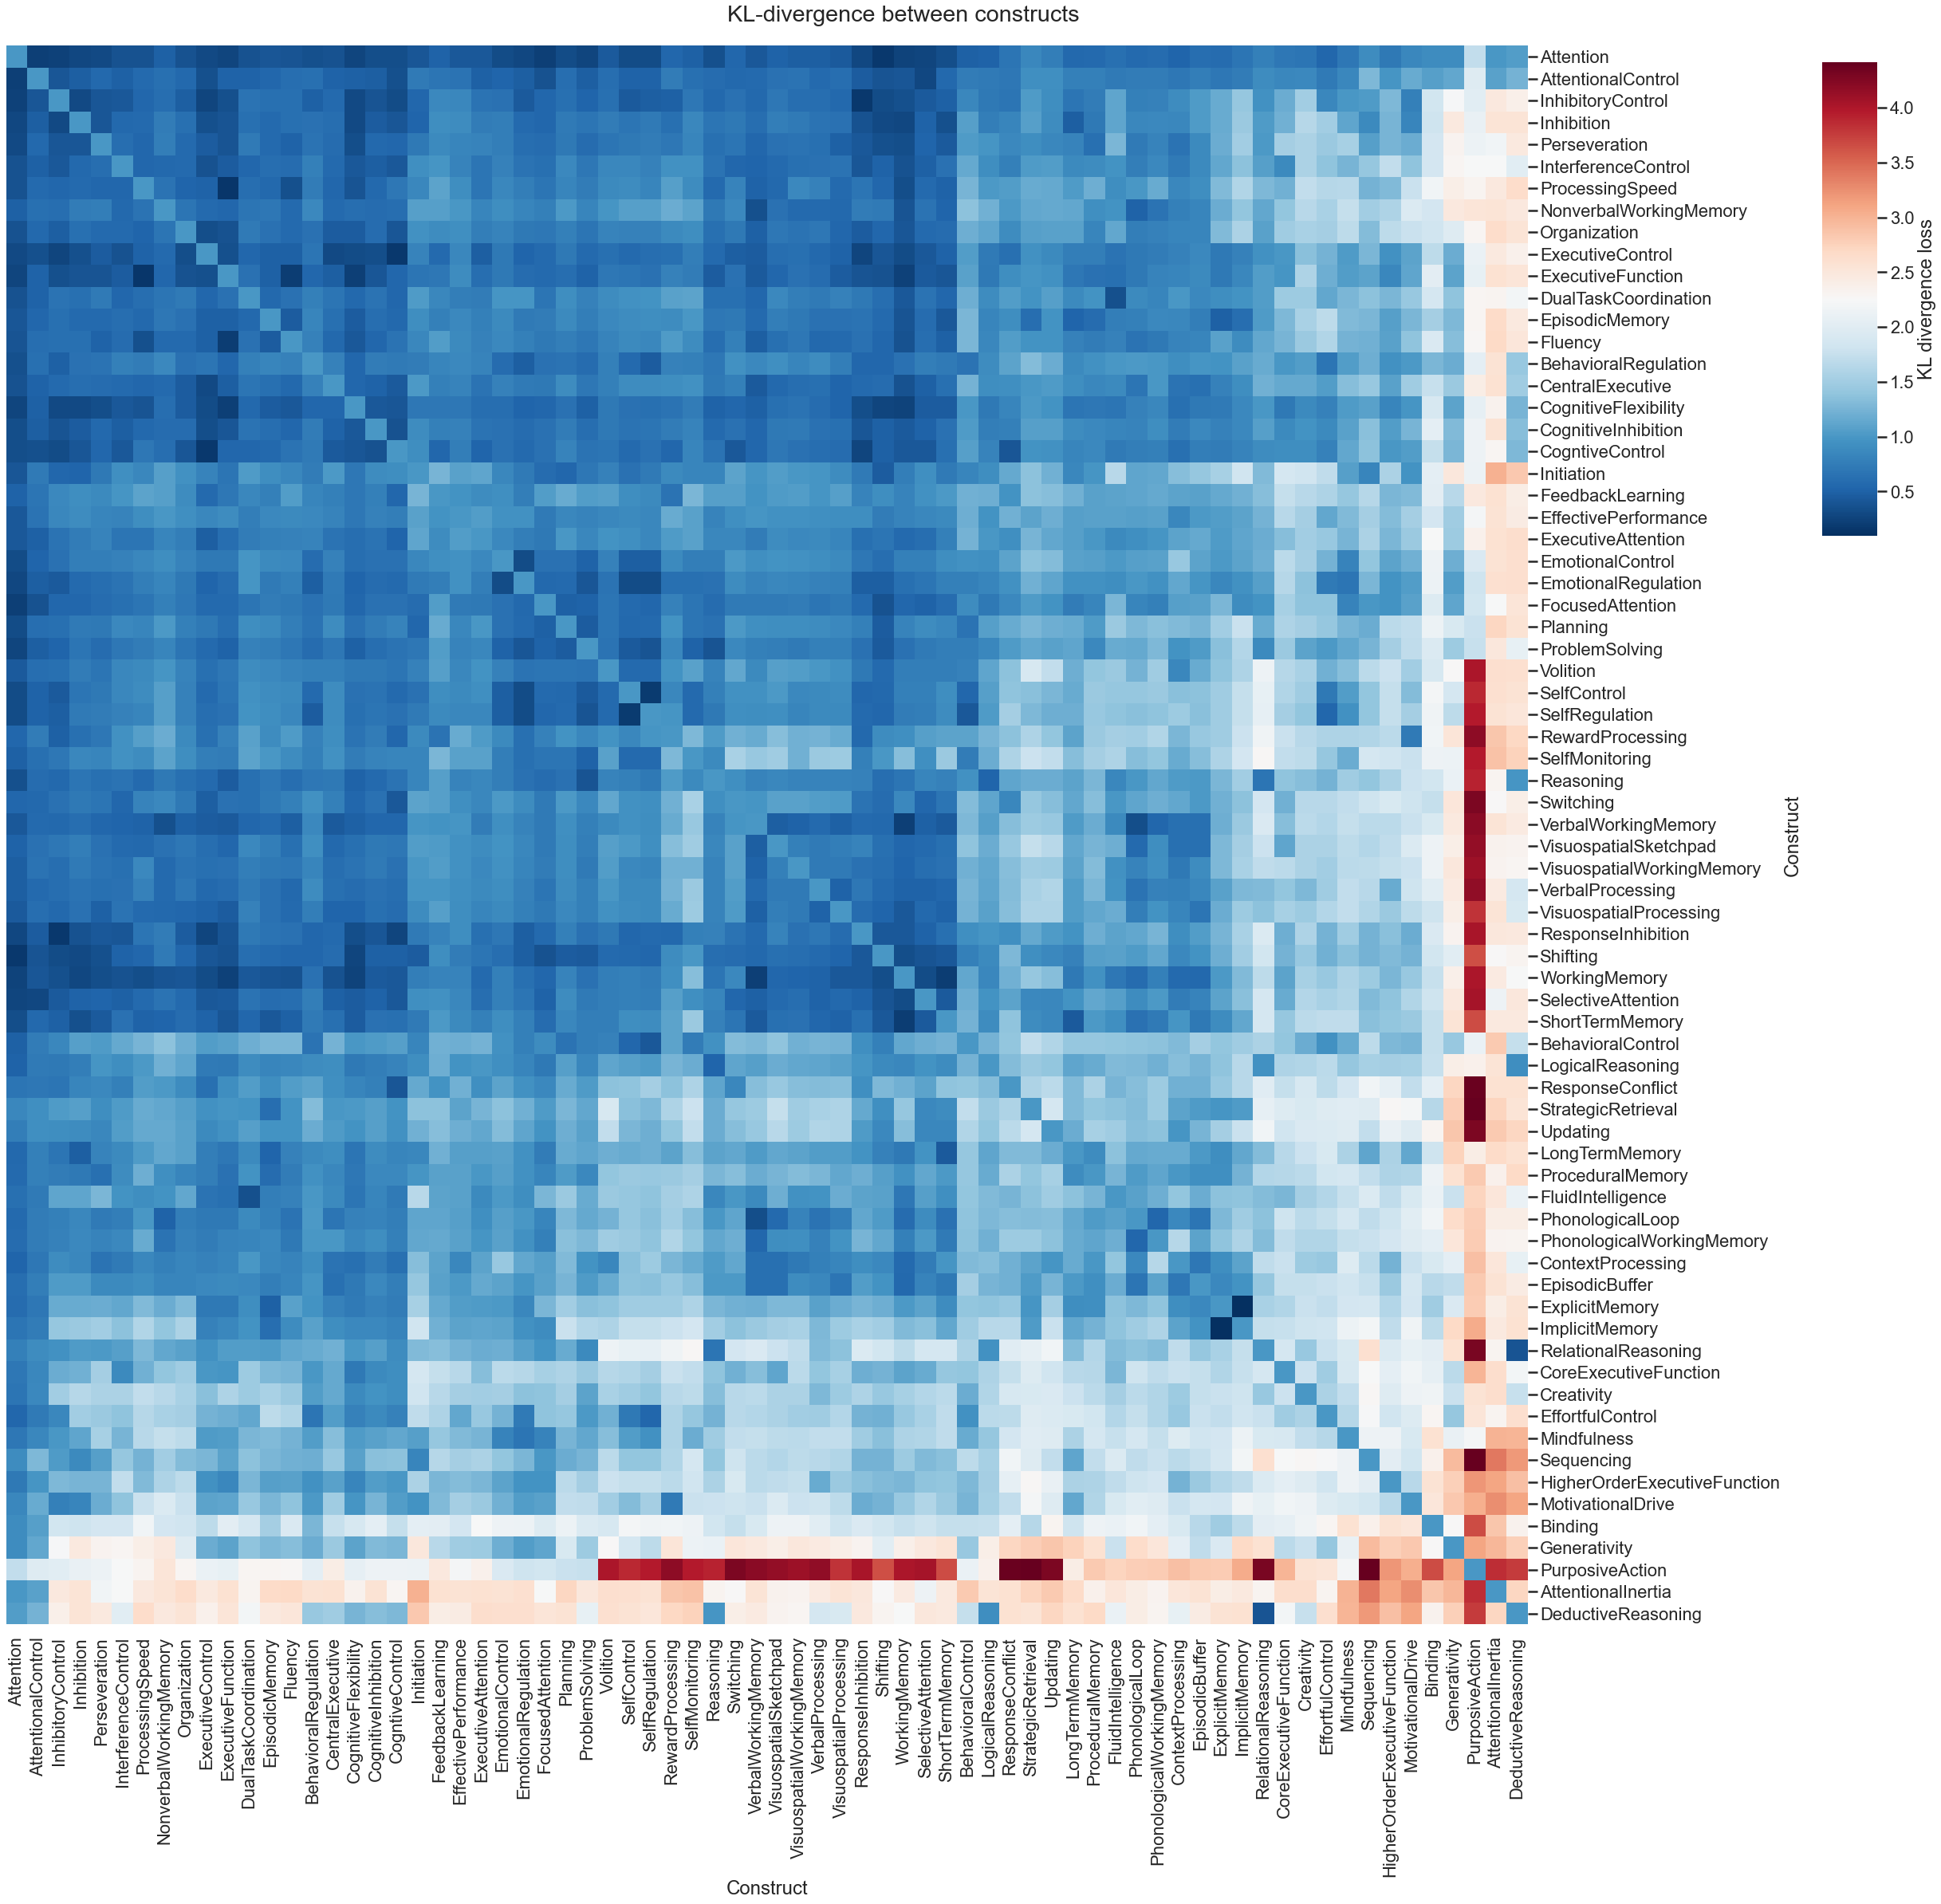

In [150]:
# plot kl-divergence between construct labels, ignoring the task labels.

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def kl_div(p,q):
  P = tfd.Categorical(probs=p)
  Q = tfd.Categorical(probs=q)
  return tfd.kl_divergence(P,Q)
  
X = label_embeddings.query('category.str.contains("Construct")').T

X.columns = X.columns.droplevel(1)
kl_sims = X.corr(method=kl_div)

sns.set('poster')
g = sns.clustermap(kl_sims,figsize=(32,33), dendrogram_ratio=0.0001,
               cbar_pos=(1.0, 0.73, 0.03, 0.25),
               cmap='RdBu_r', cbar_kws={'label': 'KL divergence loss'})
g.ax_heatmap.set(xlabel='Construct', ylabel='Construct')
plt.suptitle('KL-divergence between constructs',y=1.01)
plt.show()

In [147]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext

Last updated: 2021-12-06T14:20:00.908710+01:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
scikit-learn  : 0.0
python.cogtext: 0.1.2021120613

sys                   : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:19) 
[Clang 11.1.0 ]
tensorflow            : 2.7.0
tensorflow_probability: 0.14.1
numpy                 : 1.20.3
pandas                : 1.3.4
matplotlib            : 3.4.3
seaborn               : 0.11.2

